## 填充和步幅
假设输⼊形状为nh × nw，卷积核形状为kh × kw，那么输出形
状将是(nh − kh + 1) × (nw − kw + 1)。因此，卷积的输出形状取决于输⼊形状和卷积核的形状。  

还有什么因素会影响输出的⼤⼩呢？本节我们将介绍填充（padding）和步幅（stride）。假设以下情景：有
时，在应⽤了连续的卷积之后，我们最终得到的输出远⼩于输⼊⼤⼩。这是由于卷积核的宽度和⾼度通常⼤
于1所导致的。⽐如，⼀个240 × 240像素的图像，经过10层5 × 5的卷积后，将减少到200 × 200像素。如此⼀
来，原始图像的边界丢失了许多有⽤信息。⽽填充是解决此问题最有效的⽅法；有时，我们可能希望⼤幅降
低图像的宽度和⾼度。例如，如果我们发现原始的输⼊分辨率⼗分冗余。步幅则可以在这类情况下提供帮助。

### 填充
如上所述，在应⽤多层卷积时，我们常常丢失边缘像素。由于我们通常使⽤⼩卷积核，因此对于任何单个卷
积，我们可能只会丢失⼏个像素。但随着我们应⽤许多连续卷积层，累积丢失的像素数就多了。解决这个问
题的简单⽅法即为填充（padding）：在输⼊图像的边界填充元素（通常填充元素是0）。

例如，在 图6.3.1中，
我们将3 × 3输⼊填充到5 × 5，那么它的输出就增加为4 × 4。阴影部分是第⼀个输出元素以及⽤于输出计算
的输⼊和核张量元素：0 × 0 + 0 × 1 + 0 × 2 + 0 × 3 = 0。  

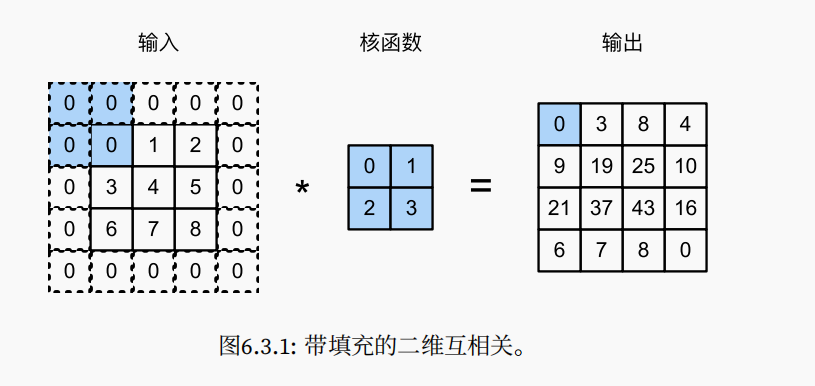

In [1]:
import torch
from torch import nn

# 为了⽅便起⻅，定义了⼀个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输⼊和输出提⾼和缩减相应的维数
def comp_conv2d(conv2d, X):
    # 这⾥的（1，1）表⽰批量⼤⼩和通道数都是1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # 省略前两个维度：批量⼤⼩和通道
    return Y.reshape(Y.shape[2:])

# 请注意，这⾥每边都填充了1⾏或1列，因此总共添加了2⾏或2列
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

当卷积核的⾼度和宽度不同时，我们可以填充不同的⾼度和宽度，使输出和输⼊具有相同的⾼度和宽度。在
如下⽰例中，我们使⽤⾼度为5，宽度为3的卷积核，⾼度和宽度两边的填充分别为2和1。

In [2]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

### 步幅
在计算互相关时，卷积窗⼝从输⼊张量的左上⻆开始，向下、向右滑动。在前⾯的例⼦中，我们默认每次滑动
⼀个元素。但是，有时候为了⾼效计算或是缩减采样次数，卷积窗⼝可以跳过中间位置，每次滑动多个元素。

将每次滑动元素的数量称为步幅（stride）。到⽬前为⽌，我们只使⽤过⾼度或宽度为1的步幅，那么如何
使⽤较⼤的步幅呢？图6.3.2是垂直步幅为3，⽔平步幅为2的⼆维互相关运算。着⾊部分是输出元素以及⽤于
输出计算的输⼊和内核张量元素：0 × 0 + 0 × 1 + 1 × 2 + 2 × 3 = 8、0 × 0 + 6 × 1 + 0 × 2 + 0 × 3 = 6。

可以看到，为了计算输出中第⼀列的第⼆个元素和第⼀⾏的第⼆个元素，卷积窗⼝分别向下滑动三⾏和向右
滑动两列。但是，当卷积窗⼝继续向右滑动两列时，没有输出，因为输⼊元素⽆法填充窗⼝（除⾮我们添加
另⼀列填充）。

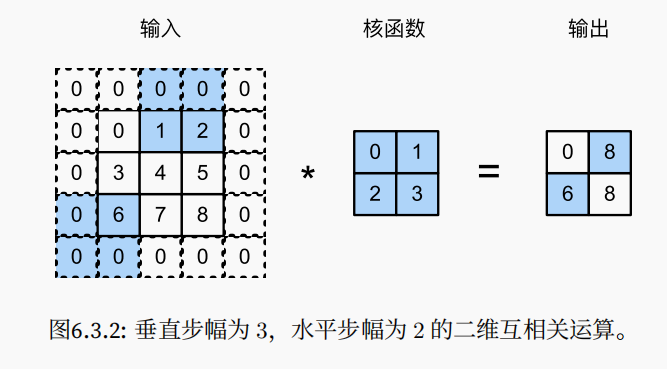

通常，当垂直步幅为sh、⽔平步幅为sw时，输出形状为  
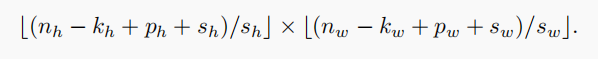  

如果我们设置了ph = kh − 1和pw = kw − 1，则输出形状将简化为⌊(nh + sh − 1)/sh⌋ × ⌊(nw + sw − 1)/sw⌋。
更进⼀步，如果输⼊的⾼度和宽度可以被垂直和⽔平步幅整除，则输出形状将为(nh/sh) × (nw/sw)。  

下⾯，我们将⾼度和宽度的步幅设置为2，从⽽将输⼊的⾼度和宽度减半。

In [3]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [4]:
# 看⼀个稍微复杂的例⼦
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

## 小结
* 填充可以增加输出的⾼度和宽度。这常⽤来使输出与输⼊具有相同的⾼和宽。
* 步幅可以减⼩输出的⾼和宽，例如输出的⾼和宽仅为输⼊的⾼和宽的1/n（n是⼀个⼤于1的整数）。
* 填充和步幅可⽤于有效地调整数据的维度。